In [1]:

import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text



In [3]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = Concatenate(axis=1)([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    # print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes=True)

    return model

model = define_model(vocab_size=8764, max_length=32)

In [4]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open(r"C:\Users\Baban\Desktop\pp\model\tokenizer.p","rb"))
model.load_weights(r'C:\Users\Baban\Desktop\pp\model\model_7.h5')
xception_model = Xception(include_top=False, pooling="avg", weights=r'C:\Users\Baban\Desktop\pp\model\xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

1/1 [==============================] - 0s 190ms/step



start man in black and black and black and white and the other is kissing her gloved hand end


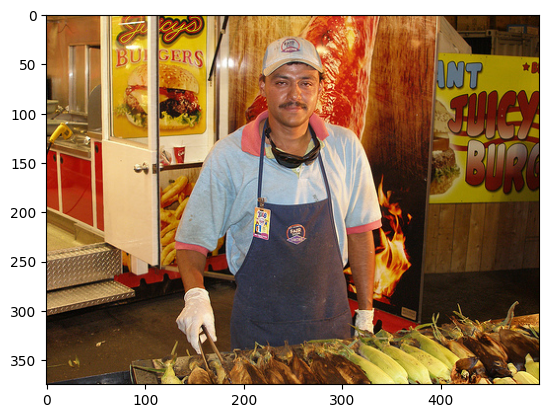

In [29]:
img_path = r'C:\Users\Baban\Desktop\pp\Flickr_Data\Images\255091930_aa2b5c0eb9.jpg'
photo = extract_features(img_path, xception_model)
img = Image.open(img_path) 

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [30]:
from keras.utils import load_img, img_to_array
from keras.applications.xception import Xception, preprocess_input

In [31]:
import json 
def decode_predictions(yhat, top=5):
    with open(r"C:\Users\Baban\Desktop\pp\model\imagenet_class_index.json") as f:
        CLASS_INDEX = json.load(f)

    results = []
    for pred in yhat:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)

    return results

1/1 [==============================] - 1s 849ms/step
['bakery', 'butcher_shop', 'grocery_store', 'rotisserie', 'plate']
start man in black and black and black and white and the other is kissing her gloved hand end


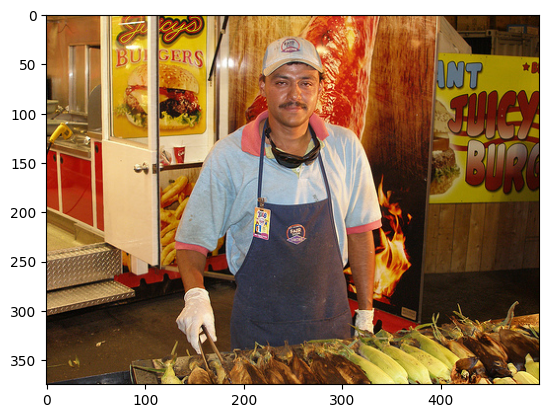

In [32]:
# load the model
obj_model = Xception(weights=r'C:\Users\Baban\Desktop\pp\model\xception_weights_tf_dim_ordering_tf_kernels.h5')
image = load_img(img_path, target_size=(299, 299))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = obj_model.predict(image)
# convert the probabilities to class labels

label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0:5]
print([x[1] for x in label] , description, sep="\n")
plt.imshow(plt.imread(img_path))